# Lesson 02: Exploring data with yt

<div class="alert alert-block alert-info">
 
## Goals:

* Exploring fields (min/max)
* Selecting regions of data
* Visualizing regions
* Filtering data
    
</div>

Now that we've learned a bit about how to load data with yt and what available objects there are in a field, we can use yt to perform analysis on those fields. 

### Exploring fields

First, let's explore some values that occur in our dat. For this tutorial we'll be using `enzo tiny cosmology`.

In [4]:
import yt
ds = yt.load_sample('enzo_tiny_cosmology')

yt : [INFO     ] 2020-03-22 18:40:15,944 Files located at /Users/madicken/yt_data/enzo_tiny_cosmology.tar.gz.untar/enzo_tiny_cosmology/
yt : [INFO     ] 2020-03-22 18:40:15,945 Default to loading DD0046/DD0046 for enzo_tiny_cosmology dataset
yt : [INFO     ] 2020-03-22 18:40:16,049 Parameters: current_time              = 230.66527489234
yt : [INFO     ] 2020-03-22 18:40:16,050 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2020-03-22 18:40:16,050 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-03-22 18:40:16,051 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-03-22 18:40:16,052 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-03-22 18:40:16,052 Parameters: current_redshift          = -2.7810863612032e-09
yt : [INFO     ] 2020-03-22 18:40:16,054 Parameters: omega_lambda              = 0.727
yt : [INFO     ] 2020-03-22 18:40:16,054 Parameters: omega_matter              = 0.273
yt : [INFO     ] 2020-03-2

This particular dataset is a *time series*. yt automatically loads the last file in a time series dataset; in this case it is `DD0046`.

Now let's explore a bit of the data contained in this file. First, let's see what fields we can explore:

In [10]:
ds.field_list

[('all', 'creation_time'),
 ('all', 'dynamical_time'),
 ('all', 'metallicity_fraction'),
 ('all', 'particle_index'),
 ('all', 'particle_mass'),
 ('all', 'particle_position_x'),
 ('all', 'particle_position_y'),
 ('all', 'particle_position_z'),
 ('all', 'particle_type'),
 ('all', 'particle_velocity_x'),
 ('all', 'particle_velocity_y'),
 ('all', 'particle_velocity_z'),
 ('enzo', 'Dark_Matter_Density'),
 ('enzo', 'Density'),
 ('enzo', 'Metal_Density'),
 ('enzo', 'Temperature'),
 ('enzo', 'TotalEnergy'),
 ('enzo', 'x-velocity'),
 ('enzo', 'y-velocity'),
 ('enzo', 'z-velocity'),
 ('io', 'creation_time'),
 ('io', 'dynamical_time'),
 ('io', 'metallicity_fraction'),
 ('io', 'particle_index'),
 ('io', 'particle_mass'),
 ('io', 'particle_position_x'),
 ('io', 'particle_position_y'),
 ('io', 'particle_position_z'),
 ('io', 'particle_type'),
 ('io', 'particle_velocity_x'),
 ('io', 'particle_velocity_y'),
 ('io', 'particle_velocity_z'),
 ('nbody', 'creation_time'),
 ('nbody', 'dynamical_time'),
 ('n

Great! That's a lot of fields. You might know that yt has a lot of tools in visualization, but it can also be used to inspect data. Here's an example where we find the extrema (the min and max) values of the "density" field. 

In [15]:
dd = ds.all_data()
dd.quantities.extrema("density")

unyt_array([1.59515116e-32, 2.56901687e-25], 'g/cm**3')

Ok, a few things have happened here. First, we've done this operation `ds.all_data()` which returns a *region* in yt based on the domain boundaries detected when the data was read in. We've returned all of the data in this dataset. 

We can check this by inspecting the `dd` object, which is a `YTRegion`. 

In [16]:
dd

YTRegion (DD0046): , center=[7.03288339e+25 7.03288339e+25 7.03288339e+25] cm, left_edge=[0. 0. 0.] cm, right_edge=[1.40657668e+26 1.40657668e+26 1.40657668e+26] cm

Region objects (and in fact any selection of the data) have **quantites** that we can use on them, but they need to be a type data selection. In the previous example, we accessed the `extrema` quantity, whcih returns a unyt array of length two of the minimum and maximum values in the density field of this dataset. 

Let's see what other quantities are available: 

In [18]:
print (list(dd.quantities.keys()))

['WeightedAverageQuantity', 'TotalQuantity', 'TotalMass', 'CenterOfMass', 'BulkVelocity', 'WeightedVariance', 'AngularMomentumVector', 'Extrema', 'SampleAtMaxFieldValues', 'MaxLocation', 'SampleAtMinFieldValues', 'MinLocation', 'SpinParameter']


ok, now let's examine what arguments we need to pass to get something we want. How about `WeightedAverageQuantity`

In [20]:
dd.quantities.weighted_average_quantity?

Signature:      dd.quantities.weighted_average_quantity(fields, weight)
Type:           WeightedAverageQuantity
String form:    <yt.data_objects.derived_quantities.WeightedAverageQuantity object at 0x11aac2550>
File:           ~/repos/yt/yt/data_objects/derived_quantities.py
Docstring:     
Calculates the weight average of a field or fields.

Returns a YTQuantity for each field requested; if one,
it returns a single YTQuantity, if many, it returns a list of YTQuantities
in order of the listed fields.

Where f is the field and w is the weight, the weighted average is
Sum_i(f_i \* w_i) / Sum_i(w_i).

Parameters
----------

fields : string / tuple, or list of strings / tuples
    The field or fields of which the average value is to be calculated.
weight : string or tuple
    The weight field.

Examples
--------

>>> ds = load("IsolatedGalaxy/galaxy0030/galaxy0030")
>>> ad = ds.all_data()
>>> print(ad.quantities.weighted_average_quantity([("gas", "density"),
...                            

and now let's calculate the temperature weighted density of this dataset:

In [21]:
dd.quantities.weighted_average_quantity("density", weight="temperature")

unyt_quantity(8.80691103e-28, 'g/cm**3')

we can also pass a list of fields with which to calculate a weighted average quantity

In [22]:
dd.quantities.weighted_average_quantity(["density", "temperature"], weight="temperature")

[unyt_quantity(8.80691103e-28, 'g/cm**3'),
 unyt_quantity(4431128.78427079, 'K')]

<div class="alert alert-block alert-warning">

## Interactive Exercise 01
    
Load in the dataset `enzo_cosmology_plus` and find the  following quantities:
    
* min and maximum values of each `enzo` field in the entire dataset
* the total gas mass in the dataset
* the `cell_volume` weighted average density
* the location of the min and max values 
    

</div>

In [ ]:
# This is starting cell to do exercise 01

<div class="alert alert-block alert-success">
 
### Tips:
    
* instead of doing `dd = ds.all_data()` and then selecting data with dens = dd["density"], yt has the option to do an automatioc `region selector` with `dens = ds.r["density"]`. `ds.r()` is a `RegionExpression` object and doesn't have any quantities associated with it. When used with a field argument, this function returns a flattened array of the data. 
* for this tutorial we've only loaded in the last file `DD0046`. However, because this is a time-series dataset there are a number of other files. yt can recognize this by loading with wildcard operators. e.g. `ts = yt.load("enzo_tiny_cosmology/DD????/DD????")`

</div>

## Volumetric Region Selectors

So far we've loaded in the entire dataset with `all_data()`. We learned that this is a special function that returns a YTRegion that spans the entire domain of the data. However, yt has other data selectors that are available, like `sphere`. Let's try to make a sphere object at a random point in our dataset.  

<div class="alert alert-block alert-warning">

## Interactive Exercise 02
    
With your previously loaded dataset `enzo_cosmology_plus` and select a region (from the available options [in the docs](https://yt-project.org/doc/analyzing/objects.html#region-reference)) in the domain center with random dimensions. 
    
Now compare the total gas mass, the min, and the max values of the density field for the region you've selected to that of the total dataset that you did in exercise 01. Do they differ? Do they look the same? 
</div>

In [ ]:
# This is a starting cell to do exercise 02 

<div class="alert alert-block alert-success">
 
### Tips:
    
* 
*
* 

</div>

## Rays and Slices 

<div class="alert alert-block alert-warning">

## Interactive Exercise 03
    
Load in the dataset `enzo_cosmology_plus` and select a cubic region in the center of it. 
</div>

In [49]:
# This is a cell to start for exercise 03 

<div class="alert alert-block alert-success">
 
### Tips:
    
* `ds.r()` gives us shorthand notation to slice our data as well. For example `ds.r[:,:, 0.5]` will return a YTSlice object at the z midplane of the dataset. 
*
* 

</div>

## Visualizing our Selections 

The `.plot()` method is an easily accessible way for us to visualize the selections we've been doing with our data. Let's try them out on the objects we've already created in the previous selection. 

<div class="alert alert-block alert-warning">

## Interactive Exercise 04
    
* create a ray object, a slice object, and an off-axis slice object in the `temperature` field and visualize them with the .plot() object. 
</div>

In [ ]:
# This is a cell to start exercise 04

<div class="alert alert-block alert-success">
 
### Tips:
    
* 
*
* 

</div>

<div class="alert alert-block alert-danger">

## Challenge Exercise
    
With `enzo_cosmology_plus`, create a selection object composed of a disk and a sphere at arbitrary locations in the data. Slice this sphere at its midpoint and visualize it with `.plot()`
</div>

In [53]:
# This is a starting cell to do the challenge exercise

# Takeaways

<div class="alert alert-block alert-success">

### There are many ways we can do the same operation with yt
### Derived quantities can be calculated on YT selection objects. These objects can be:
    
* [geometric](https://yt-project.org/doc/analyzing/objects.html#geometric-objects) (object is based on geometry)
* [filtering objects](https://yt-project.org/doc/analyzing/objects.html#filtering-and-collection-objects) (object is based on field criteria)
* [construction objects](https://yt-project.org/doc/analyzing/objects.html#construction-objects) (data is based on additional analysis)
* [collections](https://yt-project.org/doc/analyzing/objects.html#filtering-and-collection-objects) (object is a collection of other objects).
    
### 2d and 1d objects can be visualized with the `.plot()` method 

</div>

In [24]:
dd.quantities.total_mass?

Signature:      dd.quantities.total_mass()
Type:           TotalMass
String form:    <yt.data_objects.derived_quantities.TotalMass object at 0x11aac25f8>
File:           ~/repos/yt/yt/data_objects/derived_quantities.py
Docstring:     
Calculates the total mass of the object. Returns a YTArray where the
first element is total gas mass and the second element is total particle
mass.

Examples
--------

>>> ds = load("IsolatedGalaxy/galaxy0030/galaxy0030")
>>> ad = ds.all_data()
>>> print(ad.quantities.total_mass())
Call docstring: Calculate results for the derived quantity


In [44]:
dd['density'].max()

unyt_quantity(2.56901687e-25, 'g/cm**3')

In [40]:
q = ds.r[:,:,0.5]

In [60]:
ss = dd.include_above('density', 2e-30)

AttributeError: 'YTRegion' object has no attribute 'include_above'

yt : [INFO     ] 2020-03-22 22:07:37,845 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-03-22 22:07:37,846 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-03-22 22:07:37,848 Making a fixed resolution buffer of (density) 800 by 800
yt : [INFO     ] 2020-03-22 22:07:38,010 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



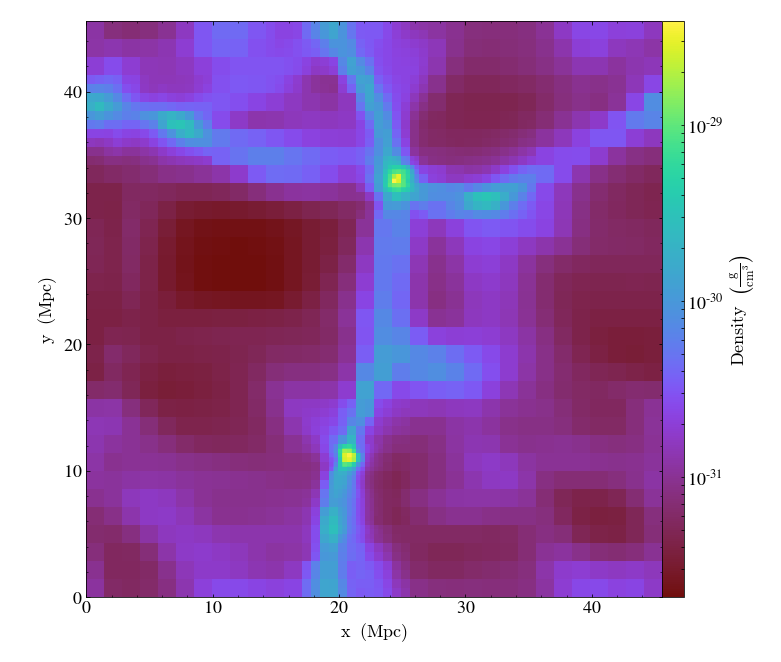


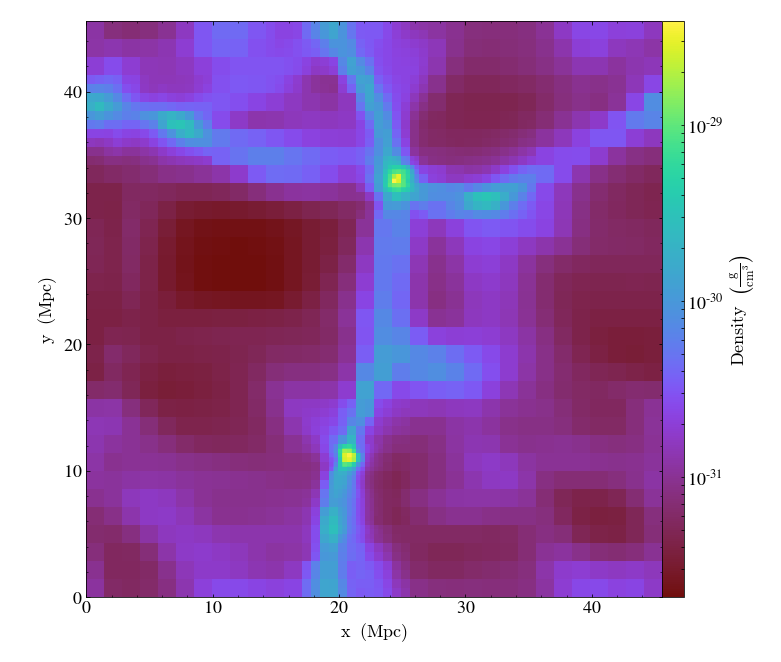

In [43]:
ss.plot('density')

In [46]:
q.quantities.extrema("density")

unyt_array([2.08363938e-32, 3.86453040e-29], 'g/cm**3')

In [47]:
r = ds.r["density"]

In [48]:
r

unyt_array([7.47519545e-32, 7.45410488e-32, 9.32374871e-32, ...,
            1.25569486e-30, 6.49324786e-31, 5.05891557e-31], 'g/cm**3')

In [58]:
q.plot?

Signature: q.plot(fields=None)
Docstring: <no docstring>
File:      ~/repos/yt/yt/data_objects/selection_data_containers.py
Type:      method
